<a href="https://colab.research.google.com/github/fahmiad/CNN-ChiliLeafDisease/blob/main/klasifikasi_cabe_alexnet_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###menyambungkan gdrive ke colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###import dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

images = []
label = []
import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Colab Notebooks/dataset/'):
    for filename in filenames:
        images.append(os.path.join(filename).split('/')[-1])
        label.append(os.path.join(dirname).split('/')[-1])

###import library yang akan digunakan

In [ ]:
import torch
import torchvision
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
from PIL import Image
import random
import time
from tqdm.notebook import tqdm
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###memperlihatkan dataset dan label

In [ ]:
IMAGE = '/content/gdrive/MyDrive/Colab Notebooks/dataset/'
TARGET_LABEL = {'keriting': 0,
                'kuning': 1,
                'sehat': 2,
                'leafspot': 3,
                'whitefly': 4}

df = pd.DataFrame({'image':images, 'label': label})
df

,image,label
0,download (39) dhennyy.jpg,keriting
1,download (55) dhennyy.jpg,keriting
2,download (15) dhenny.jpg,keriting
3,download (17) dhennyy.jpg,keriting
4,download (35) dhennyy.jpg,keriting
...,...,...
995,leaf spot01 (5) (Ahmad).jpg,leafspot
996,leaf spot01 (10) (Ahmad).jpg,leafspot
997,leaf spot01 (8) (Ahmad).jpg,leafspot
998,leaf spot01 (2) (Ahmad).jpg,leafspot


###menunjukkan presentase sebaran data

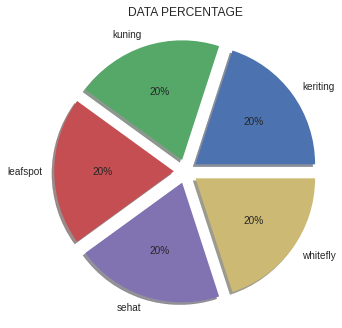

In [ ]:
label, count = np.unique(df['label'].values, return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = label, explode=[0.1, 0.1, 0.1, 0.1, 0.1],  autopct='%1.f%%', shadow=True)
plt.title('DATA PERCENTAGE')
plt.show()

###mempersiapkan fungsi untuk memuat dataset

In [ ]:
class Penyakit(Dataset):
    def __init__(self, x, y, path, map_label=TARGET_LABEL, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.X)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image'].values, df['label'].values,
    test_size=0.15, stratify=df['label'].values,
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    stratify=y_trainval, test_size=0.15,
    random_state=77)
len(X_train), len(X_val), len(X_test)

(722, 128, 150)

###memuat dataset

In [ ]:
#DATALOADER
mean = [0.5548598 , 0.54704523, 0.54043627]
std = [0.1071739 , 0.10524916, 0.10435305]
batch_size = 16

train_transform = T.Compose([T.Resize((128, 128)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])

train_set = Penyakit(X_train, y_train, IMAGE, transform=train_transform)
val_set = Penyakit(X_val, y_val, IMAGE, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                           num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False,
                                         num_workers=0, pin_memory=True)

###menunjukkan isi dari data training secara random

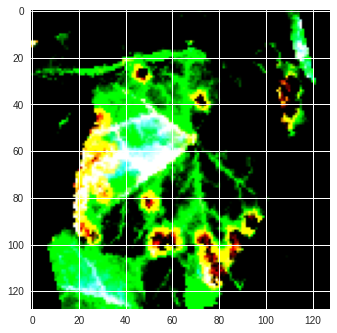

In [ ]:
img, label = train_set[random.randint(0, len(X_train))]

plt.imshow(img.permute(1,2,0))

###memuat model resnet
memuat resnet dengan 512 Neuron dan 3 class

In [ ]:
model = torchvision.models.vgg16(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=5, bias=True)
#model.classifier[6] = nn.Linear(4096, 20)
model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

###menyiapkan fungsi untuk menampung data akurasi dari proses training

akurasi = jumlah prediksi benar : jumlah total melakukan prediksi

In [ ]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 32
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

###proses training model neural network

In [ ]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
times = []
for e in range(epoch):
    model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()

        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)

        train_loss += loss
        train_acc += accuracy(output, label)

        loss.backward()
        optimizer.step()
        scheduler.step()

    else:
        with torch.no_grad():
            model.eval()

            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss

    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))

    times.append(time.time() - since)

    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

print(sum(times))

  0%|          | 0/46 [00:00<?, ?it/s]

epochs 1/32.. train loss 8.882.. val loss 5.167.. train accuracy 0.031.. val accuracy 0.047.. time 728.298 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 2/32.. train loss 2.773.. val loss 2.475.. train accuracy 0.300.. val accuracy 0.250.. time 656.083 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 3/32.. train loss 1.551.. val loss 1.331.. train accuracy 0.435.. val accuracy 0.500.. time 664.532 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 4/32.. train loss 1.012.. val loss 0.951.. train accuracy 0.628.. val accuracy 0.656.. time 653.629 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 5/32.. train loss 0.756.. val loss 0.756.. train accuracy 0.719.. val accuracy 0.695.. time 658.743 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 6/32.. train loss 0.659.. val loss 0.642.. train accuracy 0.754.. val accuracy 0.766.. time 652.737 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 7/32.. train loss 0.779.. val loss 0.957.. train accuracy 0.726.. val accuracy 0.711.. time 649.461 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 8/32.. train loss 0.625.. val loss 0.956.. train accuracy 0.784.. val accuracy 0.656.. time 641.601 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 9/32.. train loss 0.529.. val loss 0.522.. train accuracy 0.819.. val accuracy 0.828.. time 633.235 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 10/32.. train loss 0.398.. val loss 0.741.. train accuracy 0.849.. val accuracy 0.734.. time 635.603 s


  0%|          | 0/46 [00:00<?, ?it/s]

In [ ]:
time_str = float(sum(times))
print('total waktu {:.3f} s'.format(time_str))
# print(time_str)

###menampilkan grafik akurasi menggunakan matplotlib

In [ ]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

###menampilkan grafik loss menggunakan matplotlib

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend()
plt.show()

###proses pengujian data

In [ ]:
test_set = Penyakit(X_test, y_test, IMAGE, transform=val_transform)

def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

###menampilkan hasil pengujian data secara acak

In [ ]:
ints_2_label = {0: 'keriting',
                1: 'kuning',
                2: 'sehat',
                3: 'leafspot',
                4: 'whitefly'}

random_selection = np.random.randint(0, len(test_predict), 15)

fig = plt.figure(figsize=(20, 10))

test_set = Penyakit(X_test, y_test, IMAGE, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image)
    ax.set_title('True:{}\nPredict:{}'.format(ints_2_label[label], ints_2_label[test_predict[idx]]),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout() #want faster comment or delete this
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu', cbar=False)
plt.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit

plt.xticks(ticks=np.arange(0.5, len(list(TARGET_LABEL.keys()))), labels = list(TARGET_LABEL.keys()))
plt.yticks(ticks=np.arange(0.5, len(list(TARGET_LABEL.keys()))), labels = list(TARGET_LABEL.keys()))
plt.show()

In [ ]:
print(classification_report(true_label, test_predict))